In [1]:
import time
import math
import os
import torch
import torch.nn as nn
import torch.onnx
import numpy as np

import data
import model as modelScript
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

In [3]:
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

In [4]:
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target


def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(eval_batch_size)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output, hidden = model(data, hidden)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
            #total_loss += len(data) * criterion(output, targets, lamda, f_onehot, m_onehot)
            hidden = repackage_hidden(hidden)
    return total_loss / (len(data_source) - 1)

In [5]:
def getDataDir(model):
    # returns data directory for the model
    if model in ['cda.pt', 'CDA_and_lambda_0.5.pt','CDA_and_lambda_0.1.pt']:
        return '/home/urwa/Documents/Courses/NLU/GBLM/GBLM/Pytorch Model/CDA/wikitextCDA'
    else:
        return './data/wikitext-2'

In [6]:
cuda = True
seed = 20190328
batch_size = 20
#dataDir = './data/wikitext-2'

log_interval = 200

#save = 'models/lambda_0.pt'

bptt = 35
eval_batch_size = 10

In [7]:
# Set the random seed manually for reproducibility.
torch.manual_seed(seed)
if torch.cuda.is_available():
    if not cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

device = torch.device("cuda" if cuda else "cpu")

In [8]:
criterion = nn.CrossEntropyLoss()

In [9]:
modelDir = './models/'
modelFiles = [m for m in os.listdir(modelDir) if m.endswith('.pt')]
modelFiles

['lambda_0.1.pt',
 'lambda_0.5.pt',
 'lambda_0.8.pt',
 'CDA_and_lambda_0.5.pt',
 'lambda_1.pt',
 'cda.pt',
 'lambda_5.pt',
 'lambda_10.pt',
 'lambda_0.01.pt',
 'lambda_0.pt',
 'lambda_2.pt',
 'CDA_and_lambda_0.1.pt']

In [10]:
#modelFiles = ['CDA_and_lambda_0.5.pt']

In [13]:
ppx = []
for m in modelFiles:
    print('Processing: ',m)
    seed = 20190328
    torch.manual_seed(seed)
    
    dataDir = getDataDir(m)
    corpus = data.Corpus(dataDir)
    test_data = batchify(corpus.test, eval_batch_size)
    
    save = modelDir + m
    with open(save, 'rb') as f:
        model = torch.load(f)
        # after load the rnn params are not a continuous chunk of memory
        # this makes them a continuous chunk, and will speed up forward pass
        model.rnn.flatten_parameters()
    
    # Run on test data.
    test_loss = evaluate(test_data)
    print('=' * 89)
    print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
        test_loss, math.exp(test_loss)))
    print('=' * 89)
    ppx.append(math.exp(test_loss))

Processing:  lambda_0.1.pt
| End of training | test loss  4.71 | test ppl   111.03
Processing:  lambda_0.5.pt
| End of training | test loss  4.71 | test ppl   111.31
Processing:  lambda_0.8.pt
| End of training | test loss  4.72 | test ppl   112.38
Processing:  CDA_and_lambda_0.5.pt
| End of training | test loss  4.70 | test ppl   110.31
Processing:  lambda_1.pt
| End of training | test loss  4.72 | test ppl   112.31
Processing:  cda.pt
| End of training | test loss  4.71 | test ppl   111.48
Processing:  lambda_5.pt
| End of training | test loss  4.97 | test ppl   144.20
Processing:  lambda_10.pt
| End of training | test loss  5.54 | test ppl   254.17
Processing:  lambda_0.01.pt
| End of training | test loss  4.73 | test ppl   112.91
Processing:  lambda_0.pt
| End of training | test loss  4.71 | test ppl   111.14
Processing:  lambda_2.pt
| End of training | test loss  4.78 | test ppl   118.96
Processing:  CDA_and_lambda_0.1.pt
| End of training | test loss  4.71 | test ppl   110.98


In [14]:
modelNames = ['.'.join(m.split('.')[:-1]) for m in modelFiles]
modelNames

['lambda_0.1',
 'lambda_0.5',
 'lambda_0.8',
 'CDA_and_lambda_0.5',
 'lambda_1',
 'cda',
 'lambda_5',
 'lambda_10',
 'lambda_0.01',
 'lambda_0',
 'lambda_2',
 'CDA_and_lambda_0.1']

In [15]:
## Just arranging model names by lambda
mm = ['lambda_0','cda','CDA_and_lambda_0.5','CDA_and_lambda_0.1', 'lambda_0.01','lambda_0.1', 'lambda_0.5', 'lambda_0.8',\
      'lambda_1', 'lambda_2', 'lambda_5','lambda_10']
ppx = [dict(zip(modelNames,ppx))[m] for m in mm]
modelNames = mm

In [16]:
list(zip(modelNames,ppx))

[('lambda_0', 111.14198692370208),
 ('cda', 111.47552030098709),
 ('CDA_and_lambda_0.5', 110.31317542993415),
 ('CDA_and_lambda_0.1', 110.97872065551951),
 ('lambda_0.01', 112.91485985159021),
 ('lambda_0.1', 111.02678969098424),
 ('lambda_0.5', 111.30998260308019),
 ('lambda_0.8', 112.38335133100942),
 ('lambda_1', 112.30618596168217),
 ('lambda_2', 118.96417564669466),
 ('lambda_5', 144.19863588466148),
 ('lambda_10', 254.17184052516228)]

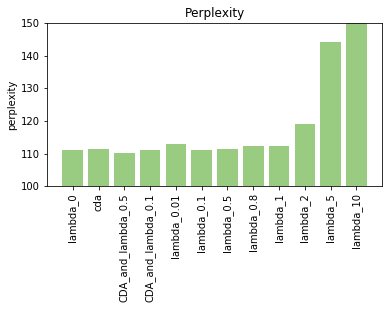

In [17]:
plt.figure(figsize=(6,3))
plt.bar(modelNames, ppx, color=(0.6, 0.8, 0.5, 1))
plt.title('Perplexity')
plt.ylabel('perplexity')
plt.ylim((100,150))
_=plt.xticks(modelNames, rotation='vertical')